### Pacakge Initialisation for UNet in PyTorch

In [4]:
import numpy as np
import torch
import os
import re
import cv2
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as func
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from IPython.display import HTML, display
from torchvision import transforms,datasets,utils
%matplotlib inline
from torch.utils.data import DataLoader, TensorDataset

### Constants

In [48]:
dataset_choices = {0:"CityScape", 1:"PennFund", 2:"MNIST"}
dataset = 1

batch_size = 5
num_epochs = 15
n_class = 2

### Utility Functions

In [64]:
def load_cityscape_dataset(datadir_trainimage, datadir_testimage):
    transform = transforms.Compose([transforms.ToTensor()]) # Converting to tensor dataset

    train_set = torchvision.datasets.Cityscapes(root = datadir_trainimage,
                                                split='train', mode='fine', target_type='semantic',
                                                transform=transform , target_transform=transform , transforms=None)
    test_set = torchvision.datasets.Cityscapes(root = datadir_testimage,
                                               split='val', mode='fine', target_type='semantic',
                                               transform=transform , target_transform=transform , transforms=None)


    # creating data loader for train and test
    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2),
        'test': DataLoader(test_set, batch_size=1, shuffle=True, num_workers=2)
    }
    
    return dataloaders
    
def laod_pennfund_dataset(datadir_trainimage, datadir_testimage):

    
    def process_images_and_masks(datadir_trainimage, datadir_testimage):
        # training images
        trainingdata=[] #empty array for saving training images as numpy array
        trainingfile=[] #empty array for saving  corresponding training file names as numpy array
        for img in os.listdir(datadir_trainimage):
            trainingfile.append(img)
            img_array =cv2.imread(os.path.join(datadir_trainimage,img),cv2.COLOR_RGB2GRAY)
            new_array = cv2.resize(img_array,(400,400))   
            trainingdata.append(np.squeeze([new_array]))

        # masking images    
        maskingdata=[] #empty array for saving target mask images as numpy array
        maskingfile = [] #empty array for saving  corresponding target mask file names as numpy array
        for i in range(len(trainingfile)):
            img = (trainingfile[i].rsplit('.png', 1)[0])+str("_mask.png")
            maskingfile.append(img)
            img_array =cv2.imread(os.path.join(datadir_testimage,img),cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array,(400,400))
            new_array[np.where(new_array>0.5)] = 1
            maskingdata.append(np.squeeze([new_array]))

        #Converting into numpy which is easy to compute
        trainingdata = np.array(trainingdata)
        maskingdata = np.array(maskingdata)
        
        return trainingdata, maskingdata

    def test_mask_plots(trainingdata, maskingdata):
        plt.imshow(maskingdata[14])
        plt.show()
        print("Unique pixels in Labels: " + str(np.unique(maskingdata[7])))
        print("Shape of Mask Labels: " + str(maskingdata[7].shape))
        print("Shape of Input Images: " + str(trainingdata[7].shape))

    
    # Pre-process dataset
    trainingdata, maskingdata = process_images_and_masks(datadir_trainimage, datadir_testimage)
    # Test Masks
    test_mask_plots(trainingdata, maskingdata)
    
        
    # Final Dataset Creator
    # RGB images obtained from CV2 has channel different than expected tensor
    a = Tensor(trainingdata)
    trainingdata_tensor = torch.empty(170,3,400,400,dtype=torch.float)
    for i, img in enumerate(a):
        trainingdata_tensor[i,:,:,:] = img.permute(2,0,1)

    # Converting to tensor dataset
    dataset_created = TensorDataset(trainingdata_tensor, Tensor(maskingdata))
    torch.manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(dataset_created, [10, 160])

    # creating data loader for train and test
    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2),
        'test': DataLoader(val_set, batch_size=1, shuffle=True, num_workers=2)
        }
    
    return dataloaders

def label_split(labels,targetimage,n_class):
    for i in range(n_class):
        if i==0:
            labels[:,0,:,:] = (targetimage == 0)==1
        else:
            labels[:,i,:,:] = (targetimage != i)==0
    return labels

### Dataset creation based on new data image

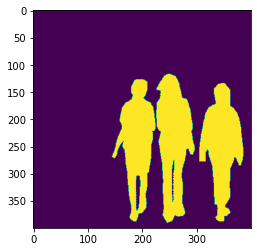

Unique pixels in Labels: [0 1]
Shape of Mask Labels: (400, 400)
Shape of Input Images: (400, 400, 3)


In [55]:
if dataset==0:
    datadir_trainimage = "../Dataset/cityscape_400x400/"
    datadir_testimage  = "../Dataset/cityscape_400x400/"
    dataloaders = load_cityscape_dataset(datadir_trainimage, datadir_testimage)
elif dataset==1:
    datadir_trainimage = "PennFudanPed/PNGImages"
    datadir_testimage  = "PennFudanPed/PedMasks"
    dataloaders = laod_pennfund_dataset(datadir_trainimage, datadir_testimage)

### UNET Models

#### 16k Params Model

In [56]:
class unet_16k(nn.Module):
    def __init__(self):
        super(unet_16k,self).__init__()

        #Encoder
        self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), nn.ReLU())
        self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU())
        self.downsampling = nn.MaxPool2d(2)

        #Decoder
        self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
        self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1), nn.ReLU())
        self.output_conv = nn.Conv2d(16, 2, 1, stride=1)
    

    def forward(self, x):

        #Encoder
        x1 = self.contractinglayer1(x)
        x2 = self.downsampling(x1)
        x3 = self.contractinglayer2(x2)
        
        #Decoder
        x4 = torch.cat([self.upsampling_2to1(x3,output_size=x1.size()), x1], dim=1)
        x5 = self.explayer5(x4)
        x6 = self.output_conv(x5)
        
        return x6   


from torchsummary import summary

model = unet_16k()
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

_ = summary(model, (3, 400, 400))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 400, 400]        --
|    └─Conv2d: 2-1                       [-1, 16, 400, 400]        448
|    └─ReLU: 2-2                         [-1, 16, 400, 400]        --
├─MaxPool2d: 1-2                         [-1, 16, 200, 200]        --
├─Sequential: 1-3                        [-1, 32, 200, 200]        --
|    └─Conv2d: 2-3                       [-1, 32, 200, 200]        4,640
|    └─ReLU: 2-4                         [-1, 32, 200, 200]        --
├─ConvTranspose2d: 1-4                   [-1, 32, 400, 400]        4,128
├─Sequential: 1-5                        [-1, 16, 400, 400]        --
|    └─Conv2d: 2-5                       [-1, 16, 400, 400]        6,928
|    └─ReLU: 2-6                         [-1, 16, 400, 400]        --
├─Conv2d: 1-6                            [-1, 2, 400, 400]         34
Total params: 16,178
Trainable params: 16,178
Non-trainable params: 0
Total

#### 100k Params Model

In [38]:
class unet_100k(nn.Module):
    def __init__(self):
        super(unet_100k,self).__init__()

        #Encoder
        self.contractinglayer1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, stride=1, padding=1), nn.ReLU())
        self.contractinglayer2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU())
        self.contractinglayer3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())
        self.downsampling = nn.MaxPool2d(2)

        #Decoder
        self.upsampling_3to2 = nn.ConvTranspose2d(64, 64, 2,stride=2, padding=0)
        self.explayer4 = nn.Sequential(nn.Conv2d(64+32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU())
        self.upsampling_2to1 = nn.ConvTranspose2d(32, 32, 2,stride=2, padding=0)
        self.explayer5 = nn.Sequential(nn.Conv2d(32+16, 16, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, stride=1, padding=1), nn.ReLU())
        self.output_conv = nn.Conv2d(16, 2, 1, stride=1)

    def forward(self, x):
        
        #Encoder
        x1 = self.contractinglayer1(x)
        x2 = self.downsampling(x1)
        x3 = self.contractinglayer2(x2)
        x4 = self.downsampling(x3)
        x5 = self.contractinglayer3(x4)
        
        #Decoder
        x6 = torch.cat([self.upsampling_3to2(x5,output_size=x3.size()), x3], dim=1)
        x7 = self.explayer4(x6)
        x8 = torch.cat([self.upsampling_2to1(x7,output_size=x1.size()), x1], dim=1)
        x9 = self.explayer5(x8)
        x10 = self.output_conv(x9)
        
        return x10   


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unet_100k()
model = model.to(device)

_ = summary(model, (3, 400, 400))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 400, 400]        --
|    └─Conv2d: 2-1                       [-1, 16, 400, 400]        448
|    └─ReLU: 2-2                         [-1, 16, 400, 400]        --
|    └─Conv2d: 2-3                       [-1, 16, 400, 400]        2,320
|    └─ReLU: 2-4                         [-1, 16, 400, 400]        --
├─MaxPool2d: 1-2                         [-1, 16, 200, 200]        --
├─Sequential: 1-3                        [-1, 32, 200, 200]        --
|    └─Conv2d: 2-5                       [-1, 32, 200, 200]        4,640
|    └─ReLU: 2-6                         [-1, 32, 200, 200]        --
|    └─Conv2d: 2-7                       [-1, 32, 200, 200]        9,248
|    └─ReLU: 2-8                         [-1, 32, 200, 200]        --
├─MaxPool2d: 1-4                         [-1, 32, 100, 100]        --
├─Sequential: 1-5                        [-1, 64, 100, 100]        --
|    

### 7M Params Model

In [40]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet_7M(nn.Module):

    def __init__(self):
        super().__init__()
              
        #Encoder
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2,stride=2)
        
        #Decoder
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 2, 1,stride=1)
        
        
    def forward(self, x):
        
        #Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        x = self.dconv_down4(x)
        
        #Decoder
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        
        return out


from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_7M()
model = model.to(device)

_ = summary(model, (3, 400, 400))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 400, 400]        --
|    └─Conv2d: 2-1                       [-1, 64, 400, 400]        1,792
|    └─ReLU: 2-2                         [-1, 64, 400, 400]        --
|    └─Conv2d: 2-3                       [-1, 64, 400, 400]        36,928
|    └─ReLU: 2-4                         [-1, 64, 400, 400]        --
├─MaxPool2d: 1-2                         [-1, 64, 200, 200]        --
├─Sequential: 1-3                        [-1, 128, 200, 200]       --
|    └─Conv2d: 2-5                       [-1, 128, 200, 200]       73,856
|    └─ReLU: 2-6                         [-1, 128, 200, 200]       --
|    └─Conv2d: 2-7                       [-1, 128, 200, 200]       147,584
|    └─ReLU: 2-8                         [-1, 128, 200, 200]       --
├─MaxPool2d: 1-4                         [-1, 128, 100, 100]       --
├─Sequential: 1-5                        [-1, 256, 100, 100]       --

## Loss Function

### Dice Loss + BCE Loss

In [63]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

from collections import defaultdict
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

def calc_loss(pred, target, bce_weight=0.5):
    bce = func.binary_cross_entropy_with_logits(pred, target).type(dtype)

    pred = torch.sigmoid(pred).type(dtype)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    return loss

def iou(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) 
    #print(intersection,union)
   
    loss = ((intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) - intersection + smooth))
    
    return loss.mean()

## Optimizer

In [44]:
# Which UNet Model?
unet = UNet_7M()

print("Architecture choosen with parameters: " + str(sum(p.numel() for p in unet.parameters())))
gpu_available = torch.cuda.is_available() 
if gpu_available:
    unet = unet.cuda()
    
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, unet.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

Architecture choosen with parameters: 7782978


## Training

In [57]:
loss_values =[]
running_loss = 0.0

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)


    scheduler.step()
    for param_group in optimizer.param_groups:
        print("LR", param_group['lr'])

    for i, data in enumerate(dataloaders['train']):
        inputimage, targetimage = data
        
        if gpu_available:
            inputimage = inputimage.cuda()

        optimizer.zero_grad()

        # Forward Pass 
        outputs = unet(inputimage)

        # Loss Calculation
        labels = torch.empty_like(outputs)
        lab_channel = (label_split(labels,targetimage,n_class))
        loss = calc_loss(outputs,lab_channel)

        # Backward Pass
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if 1: #i % 10 == 9:
            print('[%d, %5d] loss: %.10f' %(epoch + 1, i + 1, running_loss / 100))
            loss_values.append(running_loss / 170)
            running_loss = 0.0

Epoch 0/14
----------
LR 0.0001
Epoch 1/14
----------
LR 0.0001
Epoch 2/14
----------
LR 0.0001
Epoch 3/14
----------
LR 0.0001
Epoch 4/14
----------
LR 0.0001
Epoch 5/14
----------
LR 0.0001
Epoch 6/14
----------
LR 0.0001
Epoch 7/14
----------
LR 0.0001
Epoch 8/14
----------
LR 0.0001
Epoch 9/14
----------
LR 0.0001
Epoch 10/14
----------
LR 0.0001
Epoch 11/14
----------
LR 0.0001
Epoch 12/14
----------
LR 0.0001
Epoch 13/14
----------
LR 0.0001
Epoch 14/14
----------
LR 0.0001


## Testing

In [62]:
torch.save(unet.state_dict(), os.path.join("PennFudanPed/PNGImages"))

IsADirectoryError: [Errno 21] Is a directory: 'PennFudanPed/PNGImages'

In [66]:
iou_threshold = 0.6 # enter the threshold for IOU metrics
correct_prediction = 0
total_prediction = 0
for i, data in enumerate(dataloaders['test']):
    inputimage, targetimage = data
    
    if gpu_available:
        inputimage = inputimage.cuda() 
        

    prediction = unet(inputimage)
    prediction = torch.sigmoid(prediction)  
    
    labels = torch.empty_like(prediction)
    lab_channel = (label_split(labels,targetimage,n_class))

    loss_raw = ((iou(prediction,lab_channel,1e-9)).cpu())
    
    total_prediction = total_prediction + 1
    if loss_raw > iou_threshold:
      correct_prediction = correct_prediction + 1

print("IOU loss: " + str(correct_prediction/total_prediction) +str(" for IOU threshold of: ") + str(iou_threshold))

IOU loss: 0.0375 for IOU threshold of: 0.6


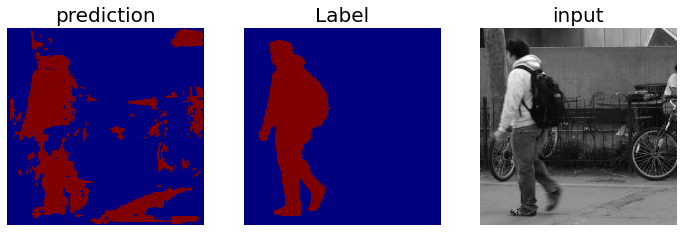

In [68]:
import math

# Get the first batch
inputs1, targetimage = next(iter(dataloaders['test']))
inputs = inputs1

# Predict
pred = unet(inputs)

# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred_max = torch.argmax(pred, dim=1)


#printing image
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12),facecolor='w')
ax1.imshow(pred_max.squeeze(0).cpu(),  interpolation='none',cmap='jet')
ax2.imshow(targetimage.squeeze(0).cpu(),  interpolation='none',cmap='jet')
ax3.imshow(inputs1[:,2,:,:].squeeze(0).cpu(),  interpolation='none',cmap='gray')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('prediction',fontsize=20)
ax2.set_title('Label',fontsize=20)
ax3.set_title('input',fontsize=20)
plt.show()